In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle as pkl
from matplotlib import gridspec
from tempfile import TemporaryFile

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import metrics_u

489


# Calibrating Utility Hyperparams According to the Data

In this notebook, we visualize the calibration of utility matrix hyperparameters. As noted by Eini-Porat, Eytan, and Shalit (2024), the relevance of accurate time series predictions is context-dependent, shaped by domain knowledge and temporal factors, which can vary by domain and time scale. To ensure the metrics align with the intended behavior, we'll start with a quick sanity check.
In this notebook we explore visulations intended to calibrate utility matrices' hyperparamters. 
As decribed in (Eini-Porat, Eytan, and Shalit 2024), the true relevance of a correct time series prediction may also depand on context, determend by domain knowlage and temporal. Therefore it is important to first 

Load an example series to get started. You may load your own example series to calibrate.

In [4]:
len_series = 492
time = time = np.tile(np.arange(len_series), 1)

In [5]:
with open('cali_series.pkl', 'rb') as f:
    series = pkl.load(f)

## Normal Range Utility Cost

The definition of exceeding the normal range depends on what is considered "normal" in the domain. The normal range function is a two-sided sigmoid, corresponding to each threshold. We define the URangeCost object, where `x0_high` and `x0_low` mark the threshold locations. The parameter `L` controls the scale, while other hyperparameters adjust the steepness of the function.

Next, we calculate the range utility cost using the `range_u_loss` function. For general use, you would set `raw=False` to calculate the overall range cost across `y_true` and `y_pred`. In this calibration phase, we keep `raw=True` to get outputs per sample, ensuring relevant events are captured. In the following examples, we use `np.mean(series)` as a filter.

In [6]:
range_cost = metrics_u.URangeCost(L=10, x0_high=np.mean(series), k_high=0.05,\
                                  b_high=0 ,x0_low=np.mean(series), k_low=0.07, b_low=0)

global_u, sample_u = range_cost.range_u_loss(series, np.mean(series), raw=True)

In [7]:
df_range = pd.DataFrame({"Time": time,
                         "id": np.ones(len_series),
                         "y": series,
                         "Range": sample_u,
                         }) 

Now we visualize. 

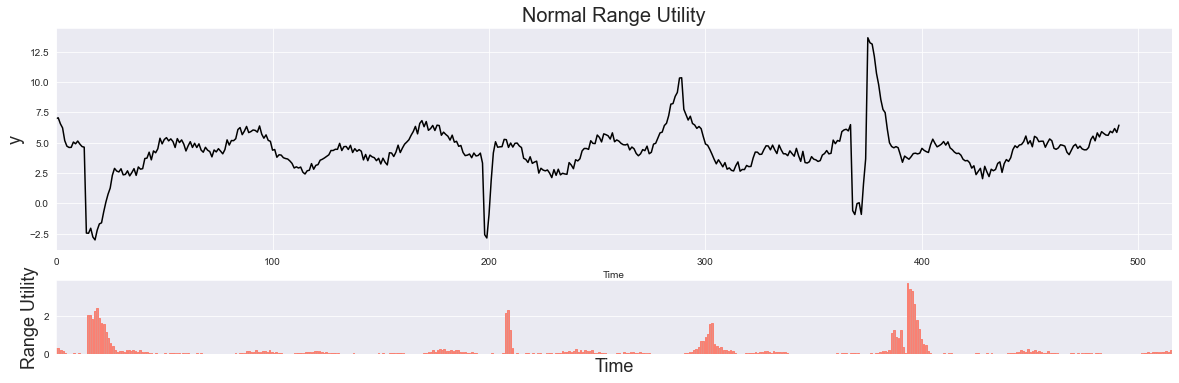

In [9]:
ylim= df_range["Time"].max()
df = df_range.loc[(df_range["id"]==0) & (df_range["Time"]<=ylim)]
cmap = matplotlib.colors.ListedColormap(['white', 'red'])
fig, ax = plt.subplots(2,1, figsize=(20, 6), gridspec_kw={'height_ratios': [3, 1]})
sns.set_style("darkgrid")

sns.lineplot(data=df_range, x='Time', y='y', ax=ax[0], color="black")

ax[0].set_title("Normal Range Utility", fontsize=20)
sns.barplot(data=df_range, x='Time', y='Range', color='salmon', edgecolor='salmon',ax=ax[1]);


ax[0].set_ylabel("y", fontsize=18)
ax[1].set_ylabel("Range Utility", fontsize=18)

ax[1].set_xlabel("Time", fontsize=18)

ax[0].set_xlim(left=0);
ax[1].set_xlim(left=0);

plt.setp(ax[1].get_xticklabels(), visible=False);

## Trend and Trend Deviation Utility Costs

The importance of trend-dependent behavior also depends on the time scale of the data. Trend and Trend deviation rely on slope calculations, which require calibration. For instance, calculating slopes over segments that are too short may result in noisy weights, while longer segments can smooth them out. Therefore, when defining a `TrendCost` object, you may need to adjust the `k` hyperparameter to calculate wider slopes. If you want to differentiate between increasing and decreasing trends, you can modify the `high` and `low` parameters to assign different weights.

We begin with trend deviation, where we calculate both $\tilde{Y}$, the expected trend based on previous examples, and $Y$, the true trend considering the new sample. For calibration purposes, we mark `raw=True` here as well.


In [10]:
k=4
trend_cost = metrics_u.TrendCost(high=1, low=1, k=4)

global_u, sample_u = trend_cost.trend_dev_loss(series, np.ones(len_series)*np.mean(series), raw=True, k=4)

In [11]:
df_trend_dev = pd.DataFrame({"Time": time[(k-1):],
                         "id": np.ones(len_series-(k-1)),
                         "y":series[(k-1):],
                         "Trend_Dev": sample_u,
                         }) 


Now we visualize. We note that since we can't compute the trend deviation costs for the first few samples (as $\tilde{Y}$ is undefined in this area) we had to fix alignment for the visualization.  

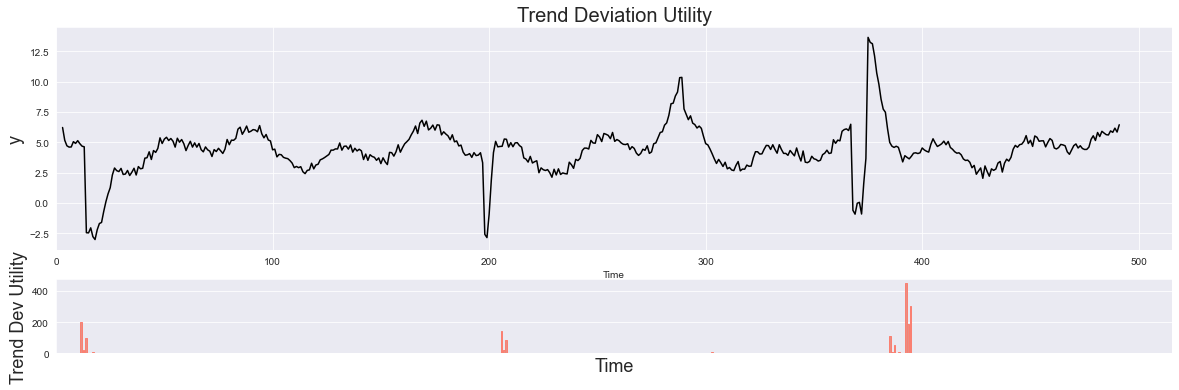

In [12]:
ylim= df_trend_dev["Time"].max() # may change to zoom in
df = df_trend_dev.loc[(df_trend_dev["id"]==0) & (df_trend_dev["Time"]<=ylim)]
cmap = matplotlib.colors.ListedColormap(['white', 'red'])
fig, ax = plt.subplots(2,1, figsize=(20, 6), gridspec_kw={'height_ratios': [3, 1]})
sns.set_style("darkgrid")

sns.lineplot(data=df_trend_dev, x='Time', y='y', ax=ax[0], color="black")

ax[0].set_title("Trend Deviation Utility", fontsize=20)
sns.barplot(data=df_trend_dev, x='Time', y='Trend_Dev', color='salmon', edgecolor='salmon',ax=ax[1]);


ax[0].set_ylabel("y", fontsize=18)
ax[1].set_ylabel("Trend Dev Utility", fontsize=18)

ax[1].set_xlabel("Time", fontsize=18)

ax[0].set_xlim(left=0);
ax[1].set_xlim(left=0);

plt.setp(ax[1].get_xticklabels(), visible=False);

For *Trend Cost* there is a very similar proceedure, except that we utilize `trend_loss` function instead. *Trend Cost* relay on calculations of $Y$ and $\hat{Y}$ slopes.

In [13]:
k=4
trend_cost = metrics_u.TrendCost(high=1, low=1)

global_u, sample_u = trend_cost.trend_loss(series, np.ones(len_series)*np.mean(series), raw=True)

In [14]:
df_trend_dev = pd.DataFrame({"Time": time[(k-1):],
                         "id": np.ones(len_series-(k-1)),
                         "y":series[(k-1):],
                         "Trend": sample_u,
                         }) 


The visualization here also require alignment since we the trend for the early samples is undefined.

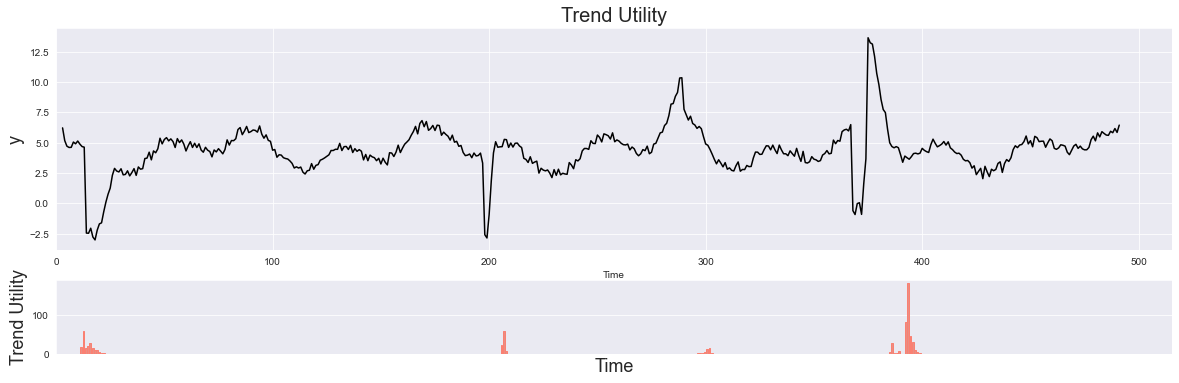

In [15]:
ylim= df_trend_dev["Time"].max()
df = df_trend_dev.loc[(df_trend_dev["id"]==0) & (df_trend_dev["Time"]<=ylim)]
cmap = matplotlib.colors.ListedColormap(['white', 'red'])
fig, ax = plt.subplots(2,1, figsize=(20, 6), gridspec_kw={'height_ratios': [3, 1]})
sns.set_style("darkgrid")

sns.lineplot(data=df_trend_dev, x='Time', y='y', ax=ax[0], color="black")

ax[0].set_title("Trend Utility", fontsize=20)
sns.barplot(data=df_trend_dev, x='Time', y='Trend', color='salmon', edgecolor='salmon',ax=ax[1]);


ax[0].set_ylabel("y", fontsize=18)
ax[1].set_ylabel("Trend Utility", fontsize=18)

ax[1].set_xlabel("Time", fontsize=18)

ax[0].set_xlim(left=0);
ax[1].set_xlim(left=0);

plt.setp(ax[1].get_xticklabels(), visible=False);